In [1216]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%pylab inline
from tqdm import tqdm

import scipy.stats
from scipy import stats

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.statespace import sarimax
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


In [657]:
# Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. 
NY = (-74.25559, -73.70001, 40.49612, 40.91553)

#### Загрузка, обработка и агрегация данных

In [658]:
def aggregate_data(fname, dataname):
    # Загрузка данных
    data = pd.read_csv(fname, header = 0, sep=',')

    # ФИЛЬТРАЦИЯ
    # Удаление поездок с нулевой длительностью
    data.drop(data[data['tpep_pickup_datetime'] == data['tpep_dropoff_datetime']].index, axis=0, inplace=True)
    data.drop(data[data['tpep_pickup_datetime'] > data['tpep_dropoff_datetime']].index, axis=0, inplace=True)

    # Удаление поездок с нулевым количеством пассажиров
    data.drop(data[data['passenger_count'] == 0].index, axis=0, inplace=True)

    # Удаление поездок с нулевым расстоянием поездки по счётчику
    data.drop(data[data['trip_distance'] == 0].index, axis=0, inplace=True)

    # Удаление поездок с координатами начала, не попадающими в прямоугольник Нью-Йорка
    data.drop(data[(data['pickup_longitude'] < -74.25559) | (data['pickup_longitude']  > -73.70001) | (data['pickup_latitude']  < 40.49612) | (data['pickup_latitude']  > 40.91553)].index, axis=0, inplace=True)

    # Новый столбец date, показывает час начала поездки
    data.insert(1, 'timestamp', data.tpep_pickup_datetime.apply(lambda x : x.split(':')[0]))

    X = data.pickup_longitude
    Y = data.pickup_latitude
    bin_count = 50
    bin_stat = stats.binned_statistic_2d(X, Y, None, statistic='count',
                                         bins=bin_count,
                                         range=[[NY[0], NY[1]], [NY[2], NY[3]]],
                                         expand_binnumbers=True)
    regions = (bin_stat.binnumber[0] - 1) * bin_count + bin_stat.binnumber[1]

    # Добавим еще один столбец - регион начала поездки
    data.insert(1, 'region_id', regions)

    # Теперь собираем аггрегированную таблицу из трех столбцов: дата, час, номер ячейки, 
    # количество поездок из этой ячейки в этот час в эту дату
    data_agg = data[['timestamp','region_id']].groupby(['region_id', 'timestamp']).size().reset_index(name='counts')
    
    # Сохраняем
    data_agg.to_csv(dataname, sep = ',', index = False, mode = 'a')

#### Подготовим данные за январь - июнь 2016 г.

In [659]:
%%time

aggregate_data('yellow_tripdata_2016-01.csv','data_agg_w5.csv')
aggregate_data('yellow_tripdata_2016-02.csv','data_agg_w5.csv')
aggregate_data('yellow_tripdata_2016-03.csv','data_agg_w5.csv')
aggregate_data('yellow_tripdata_2016-04.csv','data_agg_w5.csv')
aggregate_data('yellow_tripdata_2016-05.csv','data_agg_w5.csv')
aggregate_data('yellow_tripdata_2016-06.csv','data_agg_w5.csv')

Wall time: 13min


In [660]:
data_agg_full = pd.read_csv('data_agg_w5.csv', header = 0, sep=',')

# Удаляем лишние заголовки
data_agg_full.drop(data_agg_full.loc[data_agg_full['region_id'] == 'region_id'].index, axis = 0, inplace = True)

# Приводим к необходимому типу данных
data_agg_full['counts'] = pd.to_numeric(data_agg_full['counts'])
data_agg_full['timestamp'] = pd.to_datetime(data_agg_full['timestamp'])
data_agg_full['region_id'] = pd.to_numeric(data_agg_full['region_id'])

data_agg_full.head()

,region_id,timestamp,counts
0,16,2016-01-06 01:00:00,1
1,26,2016-01-13 05:00:00,1
2,32,2016-01-31 12:00:00,1
3,33,2016-01-21 00:00:00,1
4,46,2016-01-03 02:00:00,1


Возьмём только те ячейки, которые были отобраны на 2 неделе, а именно: из которых в мае совершается в среднем не меньше 5 поездок в час

In [661]:
rides_total = data_agg_05[['region_id','counts']].groupby(['region_id']).sum()
rides_total['mean'] = rides_total['counts']/31./24.
index2select = np.array(rides_total.loc[(rides_total['mean'] >= 5)].index)

In [662]:
# Проверка, должно получиться 102 ячейки
len(index2select)

102

In [663]:
data_agg_filtered = data_agg_full.loc[data_agg_full.region_id.isin(index2select)]

#### Прямоугольная таблица (по строкам время, по столбцам идентификатор зоны)

In [664]:
# Составим из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки
data = data_agg_filtered.pivot(index='timestamp', columns='region_id', values='counts')

data.fillna(0,inplace=True)

print data.shape
data.head()

(4368, 102)


region_id,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80.0,144.0,50.0,77.0,319.0,402.0,531.0,617.0,846.0,267.0,...,12.0,0.0,2.0,44.0,5.0,41.0,4.0,70.0,7.0,66.0
2016-01-01 01:00:00,91.0,211.0,49.0,134.0,404.0,420.0,370.0,453.0,594.0,224.0,...,29.0,0.0,5.0,2.0,2.0,4.0,0.0,47.0,1.0,29.0
2016-01-01 02:00:00,90.0,146.0,23.0,110.0,393.0,425.0,313.0,366.0,377.0,138.0,...,47.0,0.0,3.0,0.0,4.0,0.0,0.0,69.0,1.0,14.0
2016-01-01 03:00:00,32.0,87.0,16.0,62.0,252.0,399.0,324.0,309.0,327.0,166.0,...,46.0,0.0,2.0,4.0,5.0,1.0,0.0,21.0,0.0,9.0
2016-01-01 04:00:00,24.0,43.0,10.0,53.0,145.0,254.0,264.0,333.0,318.0,145.0,...,43.0,0.0,0.0,1.0,1.0,0.0,0.0,26.0,1.0,6.0


#### Создаём признаки

In [986]:
data_to_fit = pd.DataFrame()

# Регион
data_to_fit['region'] = pd.Series(np.repeat(data.columns, data.shape[0]), index=range(0, data.shape[0] * data.shape[1]))

In [987]:
# Идентификатор географической зоны — категориальный
data_to_fit = pd.concat([pd.DataFrame(data_to_fit, index=data_to_fit.index), pd.get_dummies(data_to_fit[['region']], columns=['region'])], axis=1)

In [988]:
print data_to_fit.shape
data_to_fit.head()

(445536, 103)


,region,region_1075,region_1076,region_1077,region_1125,region_1126,region_1127,region_1128,region_1129,region_1130,...,region_1630,region_1684,region_1733,region_1734,region_1783,region_2068,region_2069,region_2118,region_2119,region_2168
0,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [989]:
# Год, месяц, день месяца, день недели, час

data_to_fit['year'] = pd.Series(np.tile(np.array(pd.Series(data.index.year)), data.shape[1],),index=range(0, data.shape[0] * data.shape[1]),)
data_to_fit['month'] = pd.Series(np.tile(np.array(pd.Series(data.index.month)), data.shape[1],),index=range(0, data.shape[0] * data.shape[1]),)
data_to_fit['day'] = pd.Series(np.tile(np.array(pd.Series(data.index.day)), data.shape[1],),index=range(0, data.shape[0] * data.shape[1]),)
data_to_fit['weekday']  = pd.Series(np.tile(np.array(pd.Series(data.index.weekday)), data.shape[1],),index=range(0, data.shape[0] * data.shape[1]),)
data_to_fit['hour']  = pd.Series(np.tile(np.array(pd.Series(data.index.hour)), data.shape[1],),index=range(0, data.shape[0] * data.shape[1]),)

In [990]:
print data_to_fit.shape
data_to_fit.head()

(445536, 108)


,region,region_1075,region_1076,region_1077,region_1125,region_1126,region_1127,region_1128,region_1129,region_1130,...,region_2068,region_2069,region_2118,region_2119,region_2168,year,month,day,weekday,hour
0,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2016,1,1,4,0
1,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2016,1,1,4,1
2,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2016,1,1,4,2
3,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2016,1,1,4,3
4,1075,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2016,1,1,4,4


Для учёта недельной сезонности используем регрессионные признаки следующего вида:

$$ s_i = sin([1,...,T]*2*\pi/168),$$

$$ c_i = cos([1,...,T]*2*\pi/168),  i = 1,...,K.$$

Здесь T — это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра K = 2, мы подобрали его на 2 недели.

In [991]:
def sin_cos(K, index):
    sin_cos = pd.DataFrame()
    for T in range(1, K+1):
        # 168 — длительность недели в часах
        sin_cos['s'+str(T)] = map(lambda i: math.sin(2 * T * math.pi * i / 168), index)
        sin_cos['c'+str(T)] = map(lambda i: math.cos(2 * T * math.pi * i / 168), index)
    return sin_cos

In [992]:
K_sin_cos = 2
data_to_fit = pd.concat([data_to_fit, sin_cos(K_sin_cos, range(0, data.shape[0] * data.shape[1]))], axis=1)

In [993]:
print data_to_fit.shape
data_to_fit.head()

(445536, 112)


,region,region_1075,region_1076,region_1077,region_1125,region_1126,region_1127,region_1128,region_1129,region_1130,...,region_2168,year,month,day,weekday,hour,s1,c1,s2,c2
0,1075,1,0,0,0,0,0,0,0,0,...,0,2016,1,1,4,0,0.000000,1.000000,0.000000,1.000000
1,1075,1,0,0,0,0,0,0,0,0,...,0,2016,1,1,4,1,0.037391,0.999301,0.074730,0.997204
2,1075,1,0,0,0,0,0,0,0,0,...,0,2016,1,1,4,2,0.074730,0.997204,0.149042,0.988831
3,1075,1,0,0,0,0,0,0,0,0,...,0,2016,1,1,4,3,0.111964,0.993712,0.222521,0.974928
4,1075,1,0,0,0,0,0,0,0,0,...,0,2016,1,1,4,4,0.149042,0.988831,0.294755,0.955573


Количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1},..., y_{T-K}, где K = 6$

In [994]:
def y_T(data, index, shift):
    res = np.array([])
    for c in data.columns:
        res = np.concatenate([res, np.array(data[[c]].shift(shift)).reshape(1, data.shape[0])[0]])
    return pd.Series(res, index=index)

In [995]:
data_to_fit['y'] = y_T(data, range(0, data.shape[0] * data.shape[1]), 0)
data_to_fit['y-1'] = y_T(data, range(0, data.shape[0] * data.shape[1]), -1)
data_to_fit['y-2'] = y_T(data, range(0, data.shape[0] * data.shape[1]), -2)
data_to_fit['y-3'] = y_T(data, range(0, data.shape[0] * data.shape[1]), -3)
data_to_fit['y-4'] = y_T(data, range(0, data.shape[0] * data.shape[1]), -4)
data_to_fit['y-5'] = y_T(data, range(0, data.shape[0] * data.shape[1]), -5)
data_to_fit['y-6'] = y_T(data, range(0, data.shape[0] * data.shape[1]), -6)

In [996]:
print data_to_fit.shape
data_to_fit.head()

(445536, 119)


,region,region_1075,region_1076,region_1077,region_1125,region_1126,region_1127,region_1128,region_1129,region_1130,...,c1,s2,c2,y,y-1,y-2,y-3,y-4,y-5,y-6
0,1075,1,0,0,0,0,0,0,0,0,...,1.000000,0.000000,1.000000,80.0,91.0,90.0,32.0,24.0,11.0,7.0
1,1075,1,0,0,0,0,0,0,0,0,...,0.999301,0.074730,0.997204,91.0,90.0,32.0,24.0,11.0,7.0,9.0
2,1075,1,0,0,0,0,0,0,0,0,...,0.997204,0.149042,0.988831,90.0,32.0,24.0,11.0,7.0,9.0,18.0
3,1075,1,0,0,0,0,0,0,0,0,...,0.993712,0.222521,0.974928,32.0,24.0,11.0,7.0,9.0,18.0,22.0
4,1075,1,0,0,0,0,0,0,0,0,...,0.988831,0.294755,0.955573,24.0,11.0,7.0,9.0,18.0,22.0,27.0


Количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48},...,y_{T-24*K_d}$, мы положим $K_d=2$

In [997]:
#Предыдущие значения (y_K-24, y_K-48)
def y_T24K_d(data, K, step):
    res = []
    for r in data.columns:
            for i, d in enumerate(data.index):
                values = []
                for j in range(i, i-K, -step):
                    if j >= 0:
                        values.append(data.at[data.index[j], r])
                    else:
                        values.append(None)
                res.append(values)
                
    columns = []
    for k in range(0 * step, -K, -step):
        columns.append('T-' + str(abs(k)))
        
    if step == 1:
        return pd.DataFrame(res, columns=columns)
    else:
        return pd.DataFrame(res, columns=columns).drop(labels=['T-0'], axis=1)

In [998]:
K_d = 2
data_to_fit = pd.concat([data_to_fit, y_T24K_d(data, (K_d + 1) * 24, 24)], axis=1)

In [999]:
print data_to_fit.shape
data_to_fit.head()

(445536, 121)


,region,region_1075,region_1076,region_1077,region_1125,region_1126,region_1127,region_1128,region_1129,region_1130,...,c2,y,y-1,y-2,y-3,y-4,y-5,y-6,T-24,T-48
0,1075,1,0,0,0,0,0,0,0,0,...,1.000000,80.0,91.0,90.0,32.0,24.0,11.0,7.0,NaN,NaN
1,1075,1,0,0,0,0,0,0,0,0,...,0.997204,91.0,90.0,32.0,24.0,11.0,7.0,9.0,NaN,NaN
2,1075,1,0,0,0,0,0,0,0,0,...,0.988831,90.0,32.0,24.0,11.0,7.0,9.0,18.0,NaN,NaN
3,1075,1,0,0,0,0,0,0,0,0,...,0.974928,32.0,24.0,11.0,7.0,9.0,18.0,22.0,NaN,NaN
4,1075,1,0,0,0,0,0,0,0,0,...,0.955573,24.0,11.0,7.0,9.0,18.0,22.0,27.0,NaN,NaN


Суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц

In [1000]:
#Сумма предыдущих значений
def sum_rides_past(data, period, index):
    res = []
    for r in data.columns:
        for i, d in enumerate(data.index):
            if i - period + 1 >= 0:
                res.append(float(data[i-period+1:i+1][[r]].sum()))
            else:
                res.append(None)
    return pd.DataFrame(res, index=index)

In [1001]:
data_to_fit['sum_rides_past_12'] = sum_rides_past(data, 12, range(0, data.shape[0] * data.shape[1]))
data_to_fit['sum_rides_past_24'] = sum_rides_past(data, 24, range(0, data.shape[0] * data.shape[1]))
data_to_fit['sum_rides_past_week'] = sum_rides_past(data, 168, range(0, data.shape[0] * data.shape[1]))

In [1019]:
print data_to_fit.shape
data_to_fit.head()

(445536, 124)


,region,region_1075,region_1076,region_1077,region_1125,region_1126,region_1127,region_1128,region_1129,region_1130,...,y-2,y-3,y-4,y-5,y-6,T-24,T-48,sum_rides_past_12,sum_rides_past_24,sum_rides_past_week
0,1075,1,0,0,0,0,0,0,0,0,...,90.0,32.0,24.0,11.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1075,1,0,0,0,0,0,0,0,0,...,32.0,24.0,11.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN
2,1075,1,0,0,0,0,0,0,0,0,...,24.0,11.0,7.0,9.0,18.0,NaN,NaN,NaN,NaN,NaN
3,1075,1,0,0,0,0,0,0,0,0,...,11.0,7.0,9.0,18.0,22.0,NaN,NaN,NaN,NaN,NaN
4,1075,1,0,0,0,0,0,0,0,0,...,7.0,9.0,18.0,22.0,27.0,NaN,NaN,NaN,NaN,NaN


Определим пики и падения с учётом недельной и суточной сезонности

In [1070]:
data_to_fit[['weekday','hour','y']].groupby([data_to_fit.weekday]).mean()

,weekday,hour,y
weekday,,,
0,0.0,11.5,136.188584
1,1.0,11.5,147.542358
2,2.0,11.5,152.358000
3,3.0,11.5,158.506944
4,4.0,11.5,162.097521
5,5.0,11.5,159.268068
6,6.0,11.5,140.230769


В среднем большее количество поездок выпадает на weekday в диапазоне от 3 до 5, включая концы, детальнее посмотрим на суточное распределение поездок.

In [1080]:
data_to_fit[['weekday','hour','y']].loc[(data_to_fit.weekday > 2) & (data_to_fit.weekday < 6)].groupby([data_to_fit.hour]).mean()

,weekday,hour,y
hour,,,
0,4,0,154.099799
1,4,1,111.532051
2,4,2,81.753771
3,4,3,58.506159
4,4,4,42.443565
5,4,5,37.711413
6,4,6,80.362996
7,4,7,136.179990
8,4,8,167.232403


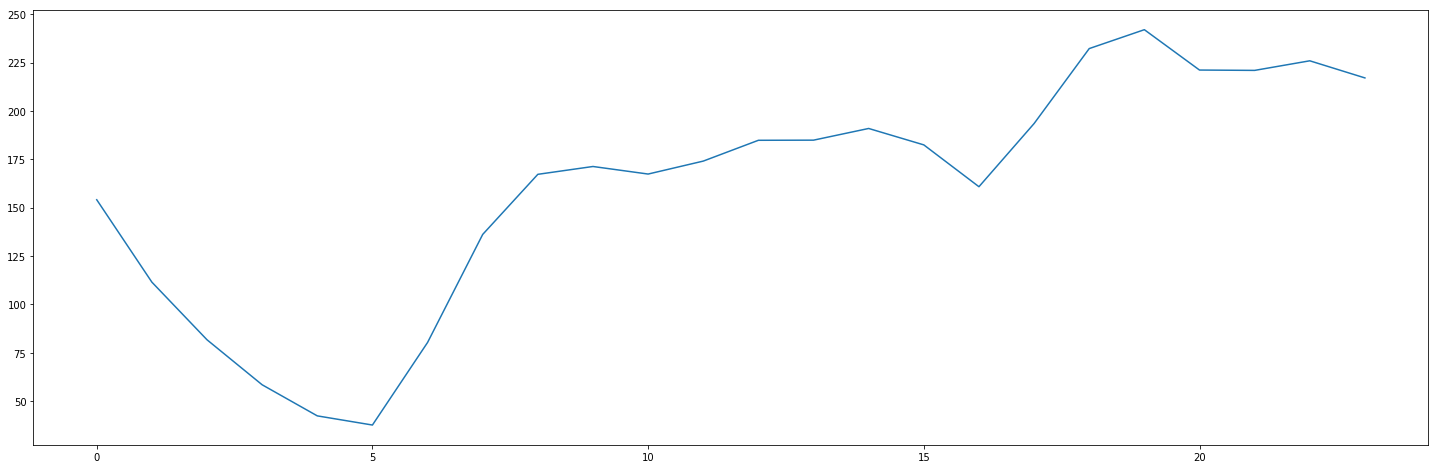

In [1084]:
plt.figure(figsize=(25, 8))
plt.plot(data_to_fit[['weekday','hour','y']].loc[(data_to_fit.weekday > 2) & (data_to_fit.weekday < 6)].groupby([data_to_fit.hour]).mean()['hour'],data_to_fit[['weekday','hour','y']].loc[(data_to_fit.weekday > 2) & (data_to_fit.weekday < 6)].groupby([data_to_fit.hour]).mean()['y'])

Начиная с 16 часов и до конца суток, возникает и держится пик.

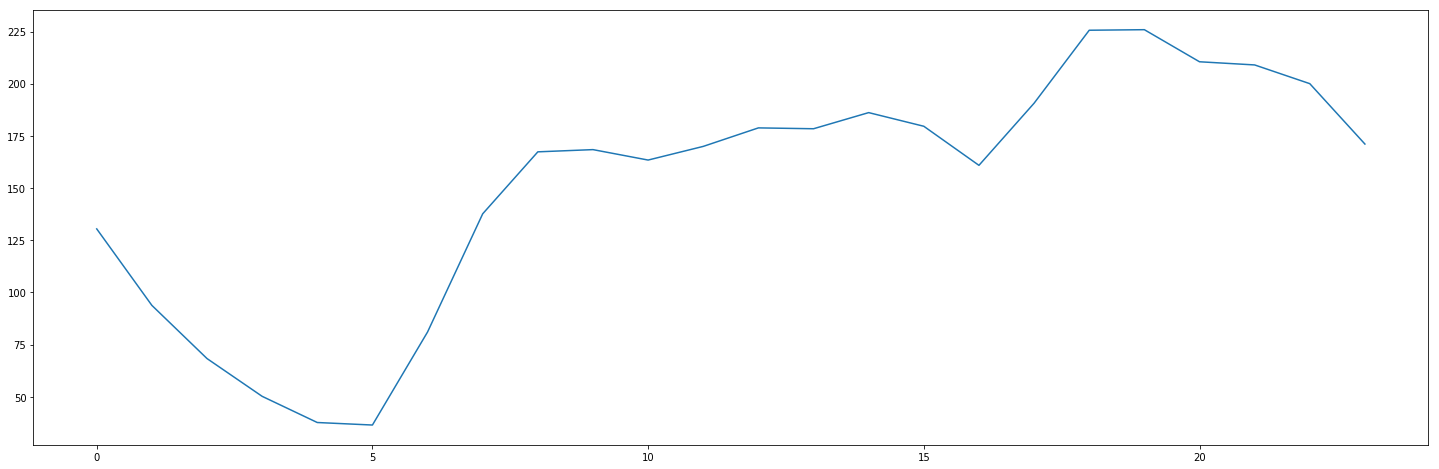

In [1083]:
plt.figure(figsize=(25, 8))
plt.plot(data_to_fit[['weekday','hour','y']].groupby([data_to_fit.hour]).mean()['hour'],data_to_fit[['weekday','hour','y']].groupby([data_to_fit.hour]).mean()['y'])

Так же видим падение с 0 и до 5 часов, вне зависимости от дня недели. Таким образом получаем следующие признаки:

In [1086]:
data_to_fit['peak_hours'] = 0
data_to_fit['fall_hours'] = 0
data_to_fit.loc[((data_to_fit['hour']>= 19) & (data_to_fit['weekday'] <= 3)), 'peak_hours'] = 1
data_to_fit.loc[data_to_fit['hour']<=7, 'fall_hours'] = 1

Предсказания модели ARIMA как признак $\hat{y}_{T+i|T}^{ARIMA}$

Для этого мы воспользуемся моделью прошлой недели и построим прогнозы на январь - апрель 2016 г. (май и июнь у нас готовы)

In [1226]:
def get_features_for_t(t, K, f):
    featues = []
    for i in range(1, K + 1):
        featues.append(f(2 * t * math.pi * i / 168))
    return featues

def get_features(length, K):
    featues = []
    for t in range(1, length + 1):
        featues.append(np.concatenate((
            get_features_for_t(t, K, math.sin),
            get_features_for_t(t, K, math.cos)
        )))
    return np.array(featues)

def plot_fitted_values(values, typical):
    plt.figure(figsize(15,7))
    pd.Series(typical[len(typical)-800:len(typical)]).plot()
    pd.Series(values[len(values)-800:len(values)]).plot(color='r')

def get_regression(y_train, X_train, X_test):
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    return np.reshape(y_pred, X_test.shape[0])

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
def process_prediction(y, lmbda, min_value):
    y_inv = invboxcox(y, lmbda)
    return y_inv - abs(min_value) - 1

def predict_single_series(train, test, features_train, features_test, model_predictions, num, month):
    regression_pred = get_regression(train, features_train, features_test)
    
    df = pd.DataFrame({0: [], 1: [], 2: [], 3: [], 4: [], 5: []})
    for i in model_predictions.index:
        predictions = np.array(regression_pred[i: i+6] + model_predictions[model_predictions.index == i])[0]
        df = df.append(
            {0: predictions[0], 1: predictions[1], 2: predictions[2], 3: predictions[3], 4: predictions[4], 5: predictions[5]},
            ignore_index=True
        )
    df.to_csv('./predictions/' + month + '/' + str(num) + '.csv')
    print 'Saved ' + str(num) + '.csv'

def predict(train, test, clusters, month):   
    features_train = get_features(train.shape[0], 10)
    features_test = get_features(train.shape[0] + test.shape[0], 10)[features_train.shape[0]:]
    features_full = np.concatenate((features_train, features_test))

    data_full = train.append(test).transpose()
    typical_series = []
    for c in range(0, n_clusters):
        typical_series.append(data_full.ix[np.array(clusters[clusters[1] == 0][[0]].transpose())[0]].mean())
        
    typical_residuals = []
    for c in range(0, n_clusters):
        regression = get_regression(typical_series[c], features_full, features_full)
        typical_residuals.append(typical_series[c] - regression)
    
    typical_residuals_box = []
    lambdas = []
    mins = []
    for c in range(0, n_clusters):
        res_min = typical_residuals[c].min()
        residuals_box, lmbda = stats.boxcox(typical_residuals[c] + abs(res_min) + 1)
        typical_residuals_box.append(residuals_box)
        lambdas.append(lmbda)
        mins.append(res_min)

    models = {
        'model0': sarimax.SARIMAXResults.load('./model0'),
        'model1': sarimax.SARIMAXResults.load('./model1'),
        'model2': sarimax.SARIMAXResults.load('./model2'),
    }
    print 'models read'
    models_fit = {}
    for c in range(0, n_clusters):
        models_fit['model' + str(c)] = sm.tsa.statespace.SARIMAX(
            typical_residuals_box[c], 
            order=models['model' + str(c)].specification['order'], 
            seasonal_order=models['model' + str(c)].specification['seasonal_order']
        ).filter(models['model' + str(c)].params)

    print 'models prepared'

    plot_fitted_values(models_fit['model0'].fittedvalues, typical_residuals_box[0])
    
    model_predictions = []
    for c in range(0, n_clusters):
        df = pd.DataFrame({0: [], 1: [], 2: [], 3: [], 4: [], 5: []})
        for time in range(train.shape[0] - 1, train.shape[0] + test.shape[0] - 6):
        #for time in range(train.shape[0], train.shape[0] + 10):
            predicted_data = models_fit['model' + str(c)].predict(time+1, time+6, dynamic=True)
            predictions = process_prediction(predicted_data, lambdas[0], mins[0])
            df = df.append(
                {0: predictions[0], 1: predictions[1], 2: predictions[2], 3: predictions[3], 4: predictions[4], 5: predictions[5]},
                ignore_index=True
            )
        model_predictions.append(df)
        print 'Predictions for cluster ' + str(c)

    for c in train.columns:
        cluster = clusters[clusters[0] == c][[1]].values[0][0]
        predict_single_series(train[[int(c)]], test[[int(c)]], features_train, features_test, model_predictions[cluster], c, month)

Для расчета прогноза необходимо добавить данные за сентябрь - декабрь 2015 г.

In [1184]:
data_to_ARIMA = data[data.columns]
print data_to_ARIMA.shape
data_to_ARIMA.head(3)

(4368, 102)


region_id,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80.0,144.0,50.0,77.0,319.0,402.0,531.0,617.0,846.0,267.0,...,12.0,0.0,2.0,44.0,5.0,41.0,4.0,70.0,7.0,66.0
2016-01-01 01:00:00,91.0,211.0,49.0,134.0,404.0,420.0,370.0,453.0,594.0,224.0,...,29.0,0.0,5.0,2.0,2.0,4.0,0.0,47.0,1.0,29.0
2016-01-01 02:00:00,90.0,146.0,23.0,110.0,393.0,425.0,313.0,366.0,377.0,138.0,...,47.0,0.0,3.0,0.0,4.0,0.0,0.0,69.0,1.0,14.0


In [1180]:
%%time

aggregate_data('yellow_tripdata_2015-09.csv','data_agg_w5_9_12.csv')
aggregate_data('yellow_tripdata_2015-10.csv','data_agg_w5_9_12.csv')
aggregate_data('yellow_tripdata_2015-11.csv','data_agg_w5_9_12.csv')
aggregate_data('yellow_tripdata_2015-12.csv','data_agg_w5_9_12.csv')

Wall time: 9min 27s


In [1186]:
data_agg_9_12 = pd.read_csv('data_agg_w5_9_12.csv', header = 0, sep=',')

# Удаляем лишние заголовки
data_agg_9_12.drop(data_agg_9_12.loc[data_agg_9_12['region_id'] == 'region_id'].index, axis = 0, inplace = True)

# Приводим к необходимому типу данных
data_agg_9_12['counts'] = pd.to_numeric(data_agg_9_12['counts'])
data_agg_9_12['timestamp'] = pd.to_datetime(data_agg_9_12['timestamp'])
data_agg_9_12['region_id'] = pd.to_numeric(data_agg_9_12['region_id'])

data_agg_filtr_9_12 = data_agg_9_12.loc[data_agg_9_12.region_id.isin(index2select)]

# Составим из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки
data_2015_9_12 = data_agg_filtr_9_12.pivot(index='timestamp', columns='region_id', values='counts')

data_2015_9_12.fillna(0,inplace=True)

data_to_ARIMA = data_to_ARIMA.append(data_2015_9_12)

print data_to_ARIMA.shape
data_to_ARIMA.head(3)

(7296, 102)


region_id,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80.0,144.0,50.0,77.0,319.0,402.0,531.0,617.0,846.0,267.0,...,12.0,0.0,2.0,44.0,5.0,41.0,4.0,70.0,7.0,66.0
2016-01-01 01:00:00,91.0,211.0,49.0,134.0,404.0,420.0,370.0,453.0,594.0,224.0,...,29.0,0.0,5.0,2.0,2.0,4.0,0.0,47.0,1.0,29.0
2016-01-01 02:00:00,90.0,146.0,23.0,110.0,393.0,425.0,313.0,366.0,377.0,138.0,...,47.0,0.0,3.0,0.0,4.0,0.0,0.0,69.0,1.0,14.0


#### Прямоугольная таблица за январь 2016 (по строкам время, по столбцам идентификатор зоны)

In [1187]:
aggregate_data('yellow_tripdata_2016-01.csv','data_agg_01.csv')

data_agg_01 = pd.read_csv('data_agg_01.csv', header = 0, sep=',')

# Приводим к необходимому типу данных
data_agg_01['counts'] = pd.to_numeric(data_agg_01['counts'])
data_agg_01['timestamp'] = pd.to_datetime(data_agg_01['timestamp'])
data_agg_01['region_id'] = pd.to_numeric(data_agg_01['region_id'])

data_agg_01_filtered = data_agg_01.loc[data_agg_01.region_id.isin(index2select)]
data_01 = data_agg_01_filtered.pivot(index='timestamp', columns='region_id', values='counts')

data_01.fillna(0,inplace=True)
data_01_t = data_01.transpose(copy=True)

#### Прямоугольная таблица за февраль 2016 (по строкам время, по столбцам идентификатор зоны)

In [1188]:
aggregate_data('yellow_tripdata_2016-02.csv','data_agg_02.csv')

data_agg_02 = pd.read_csv('data_agg_02.csv', header = 0, sep=',')

# Приводим к необходимому типу данных
data_agg_02['counts'] = pd.to_numeric(data_agg_02['counts'])
data_agg_02['timestamp'] = pd.to_datetime(data_agg_02['timestamp'])
data_agg_02['region_id'] = pd.to_numeric(data_agg_02['region_id'])

data_agg_02_filtered = data_agg_02.loc[data_agg_02.region_id.isin(index2select)]
data_02 = data_agg_02_filtered.pivot(index='timestamp', columns='region_id', values='counts')

data_02.fillna(0,inplace=True)
data_02_t = data_02.transpose(copy=True)

#### Прямоугольная таблица за март 2016 (по строкам время, по столбцам идентификатор зоны)

In [1189]:
aggregate_data('yellow_tripdata_2016-03.csv','data_agg_03.csv')

data_agg_03 = pd.read_csv('data_agg_03.csv', header = 0, sep=',')

# Приводим к необходимому типу данных
data_agg_03['counts'] = pd.to_numeric(data_agg_03['counts'])
data_agg_03['timestamp'] = pd.to_datetime(data_agg_03['timestamp'])
data_agg_03['region_id'] = pd.to_numeric(data_agg_03['region_id'])

data_agg_03_filtered = data_agg_03.loc[data_agg_03.region_id.isin(index2select)]
data_03 = data_agg_03_filtered.pivot(index='timestamp', columns='region_id', values='counts')

data_03.fillna(0,inplace=True)
data_03_t = data_03.transpose(copy=True)

#### Прямоугольная таблица за апрель 2016 (по строкам время, по столбцам идентификатор зоны)

In [1192]:
aggregate_data('yellow_tripdata_2016-04.csv','data_agg_04.csv')

data_agg_04 = pd.read_csv('data_agg_04.csv', header = 0, sep=',')

# Приводим к необходимому типу данных
data_agg_04['counts'] = pd.to_numeric(data_agg_04['counts'])
data_agg_04['timestamp'] = pd.to_datetime(data_agg_04['timestamp'])
data_agg_04['region_id'] = pd.to_numeric(data_agg_04['region_id'])

data_agg_04_filtered = data_agg_04.loc[data_agg_04.region_id.isin(index2select)]
data_04 = data_agg_04_filtered.pivot(index='timestamp', columns='region_id', values='counts')

data_04.fillna(0,inplace=True)
data_04_t = data_04.transpose(copy=True)

In [1209]:
#Кластеры
n_clusters = 3
clusters = pd.read_csv('./clusters.csv', header=None)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


models read
models prepared


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


Predictions for cluster 0
Predictions for cluster 1
Predictions for cluster 2
Saved 1075.csv
Saved 1076.csv
Saved 1077.csv
Saved 1125.csv
Saved 1126.csv
Saved 1127.csv
Saved 1128.csv
Saved 1129.csv
Saved 1130.csv
Saved 1131.csv
Saved 1132.csv
Saved 1172.csv
Saved 1173.csv
Saved 1174.csv
Saved 1175.csv
Saved 1176.csv
Saved 1177.csv
Saved 1178.csv
Saved 1179.csv
Saved 1180.csv
Saved 1181.csv
Saved 1182.csv
Saved 1183.csv
Saved 1184.csv
Saved 1221.csv
Saved 1222.csv
Saved 1223.csv
Saved 1224.csv
Saved 1225.csv
Saved 1227.csv
Saved 1228.csv
Saved 1229.csv
Saved 1230.csv
Saved 1231.csv
Saved 1232.csv
Saved 1233.csv
Saved 1234.csv
Saved 1235.csv
Saved 1272.csv
Saved 1273.csv
Saved 1274.csv
Saved 1278.csv
Saved 1279.csv
Saved 1280.csv
Saved 1281.csv
Saved 1282.csv
Saved 1283.csv
Saved 1284.csv
Saved 1285.csv
Saved 1286.csv
Saved 1287.csv
Saved 1326.csv
Saved 1327.csv
Saved 1331.csv
Saved 1332.csv
Saved 1333.csv
Saved 1334.csv
Saved 1335.csv
Saved 1336.csv
Saved 1337.csv
Saved 1338.csv
Saved 1

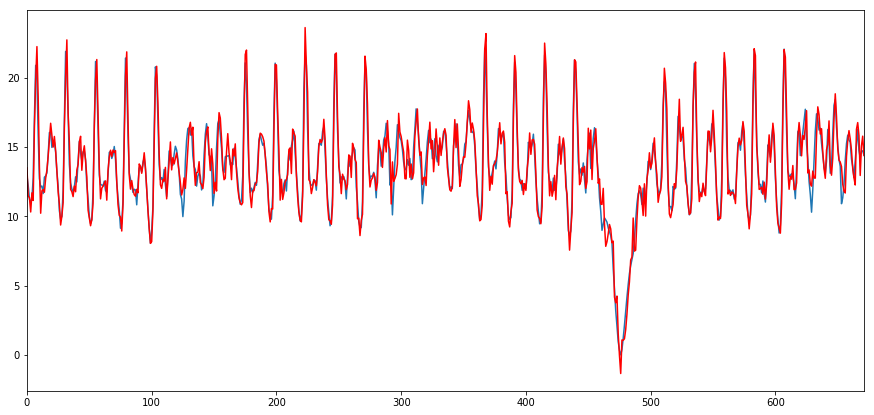

In [1222]:
%%time
predict(data_to_ARIMA.loc[(data_to_ARIMA.index < '2016-01-01 00:00:00')], data_01, clusters, 'january')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


models read
models prepared


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


Predictions for cluster 0
Predictions for cluster 1
Predictions for cluster 2
Saved 1075.csv
Saved 1076.csv
Saved 1077.csv
Saved 1125.csv
Saved 1126.csv
Saved 1127.csv
Saved 1128.csv
Saved 1129.csv
Saved 1130.csv
Saved 1131.csv
Saved 1132.csv
Saved 1172.csv
Saved 1173.csv
Saved 1174.csv
Saved 1175.csv
Saved 1176.csv
Saved 1177.csv
Saved 1178.csv
Saved 1179.csv
Saved 1180.csv
Saved 1181.csv
Saved 1182.csv
Saved 1183.csv
Saved 1184.csv
Saved 1221.csv
Saved 1222.csv
Saved 1223.csv
Saved 1224.csv
Saved 1225.csv
Saved 1227.csv
Saved 1228.csv
Saved 1229.csv
Saved 1230.csv
Saved 1231.csv
Saved 1232.csv
Saved 1233.csv
Saved 1234.csv
Saved 1235.csv
Saved 1272.csv
Saved 1273.csv
Saved 1274.csv
Saved 1278.csv
Saved 1279.csv
Saved 1280.csv
Saved 1281.csv
Saved 1282.csv
Saved 1283.csv
Saved 1284.csv
Saved 1285.csv
Saved 1286.csv
Saved 1287.csv
Saved 1326.csv
Saved 1327.csv
Saved 1331.csv
Saved 1332.csv
Saved 1333.csv
Saved 1334.csv
Saved 1335.csv
Saved 1336.csv
Saved 1337.csv
Saved 1338.csv
Saved 1

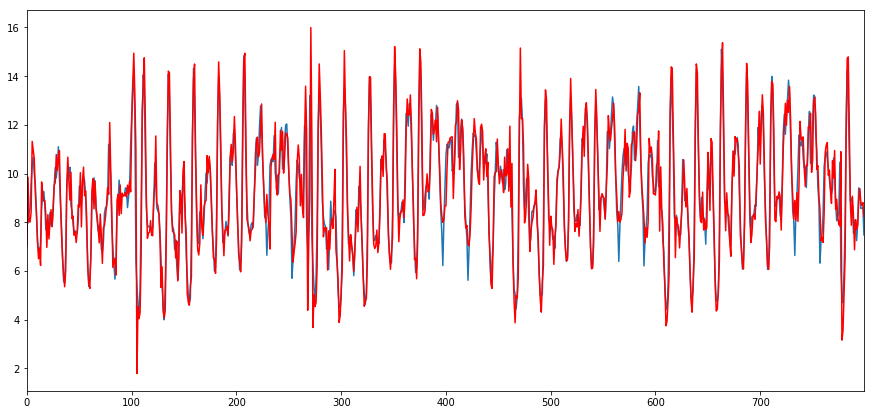

In [1227]:
%%time
predict(data_to_ARIMA.loc[(data_to_ARIMA.index > '2015-10-31 23:00:00') & (data_to_ARIMA.index < '2016-02-01 00:00:00')], data_02, clusters, 'february')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


models read
models prepared


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


Predictions for cluster 0
Predictions for cluster 1
Predictions for cluster 2
Saved 1075.csv
Saved 1076.csv
Saved 1077.csv
Saved 1125.csv
Saved 1126.csv
Saved 1127.csv
Saved 1128.csv
Saved 1129.csv
Saved 1130.csv
Saved 1131.csv
Saved 1132.csv
Saved 1172.csv
Saved 1173.csv
Saved 1174.csv
Saved 1175.csv
Saved 1176.csv
Saved 1177.csv
Saved 1178.csv
Saved 1179.csv
Saved 1180.csv
Saved 1181.csv
Saved 1182.csv
Saved 1183.csv
Saved 1184.csv
Saved 1221.csv
Saved 1222.csv
Saved 1223.csv
Saved 1224.csv
Saved 1225.csv
Saved 1227.csv
Saved 1228.csv
Saved 1229.csv
Saved 1230.csv
Saved 1231.csv
Saved 1232.csv
Saved 1233.csv
Saved 1234.csv
Saved 1235.csv
Saved 1272.csv
Saved 1273.csv
Saved 1274.csv
Saved 1278.csv
Saved 1279.csv
Saved 1280.csv
Saved 1281.csv
Saved 1282.csv
Saved 1283.csv
Saved 1284.csv
Saved 1285.csv
Saved 1286.csv
Saved 1287.csv
Saved 1326.csv
Saved 1327.csv
Saved 1331.csv
Saved 1332.csv
Saved 1333.csv
Saved 1334.csv
Saved 1335.csv
Saved 1336.csv
Saved 1337.csv
Saved 1338.csv
Saved 1

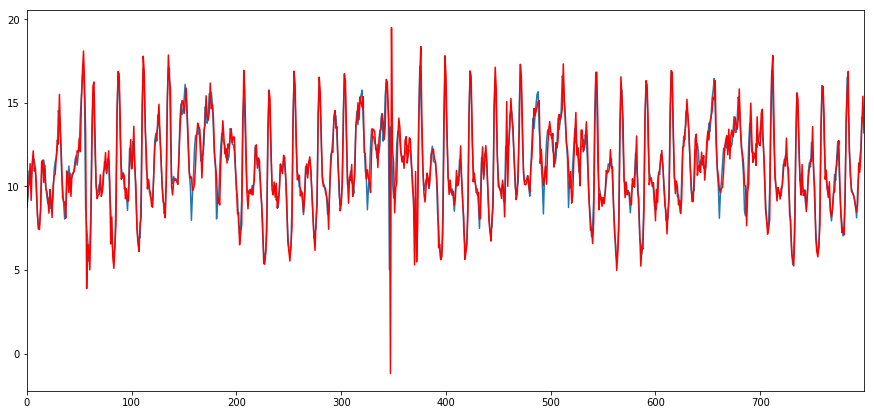

In [1228]:
%%time
predict(data_to_ARIMA.loc[(data_to_ARIMA.index > '2015-11-30 23:00:00') & (data_to_ARIMA.index < '2016-03-01 00:00:00')], data_03, clusters, 'march')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


models read
models prepared
Predictions for cluster 0
Predictions for cluster 1
Predictions for cluster 2
Saved 1075.csv
Saved 1076.csv
Saved 1077.csv
Saved 1125.csv
Saved 1126.csv
Saved 1127.csv
Saved 1128.csv
Saved 1129.csv
Saved 1130.csv
Saved 1131.csv
Saved 1132.csv
Saved 1172.csv
Saved 1173.csv
Saved 1174.csv
Saved 1175.csv
Saved 1176.csv
Saved 1177.csv
Saved 1178.csv
Saved 1179.csv
Saved 1180.csv
Saved 1181.csv
Saved 1182.csv
Saved 1183.csv
Saved 1184.csv
Saved 1221.csv
Saved 1222.csv
Saved 1223.csv
Saved 1224.csv
Saved 1225.csv
Saved 1227.csv
Saved 1228.csv
Saved 1229.csv
Saved 1230.csv
Saved 1231.csv
Saved 1232.csv
Saved 1233.csv
Saved 1234.csv
Saved 1235.csv
Saved 1272.csv
Saved 1273.csv
Saved 1274.csv
Saved 1278.csv
Saved 1279.csv
Saved 1280.csv
Saved 1281.csv
Saved 1282.csv
Saved 1283.csv
Saved 1284.csv
Saved 1285.csv
Saved 1286.csv
Saved 1287.csv
Saved 1326.csv
Saved 1327.csv
Saved 1331.csv
Saved 1332.csv
Saved 1333.csv
Saved 1334.csv
Saved 1335.csv
Saved 1336.csv
Saved 133

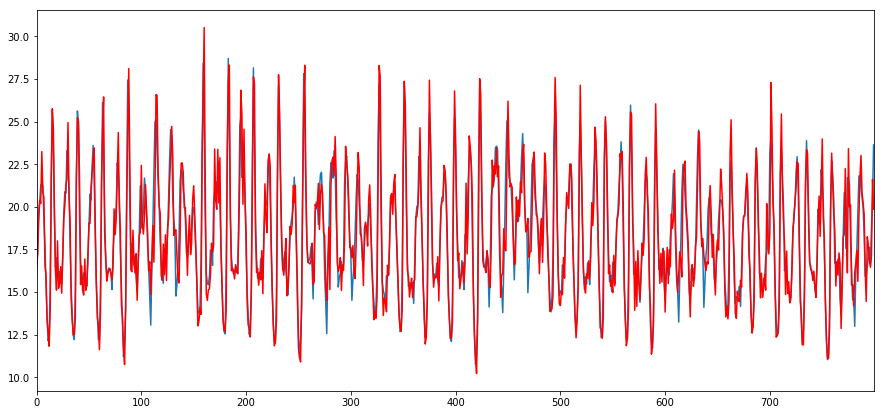

In [1229]:
%%time
predict(data_to_ARIMA.loc[(data_to_ARIMA.index > '2015-12-31 23:00:00') & (data_to_ARIMA.index < '2016-04-01 00:00:00')], data_04, clusters, 'april')

In [1230]:
data_to_fit.head()

,region,region_1075,region_1076,region_1077,region_1125,region_1126,region_1127,region_1128,region_1129,region_1130,...,y-4,y-5,y-6,T-24,T-48,sum_rides_past_12,sum_rides_past_24,sum_rides_past_week,peak_hours,fall_hours
0,1075,1,0,0,0,0,0,0,0,0,...,24.0,11.0,7.0,NaN,NaN,NaN,NaN,NaN,0,1
1,1075,1,0,0,0,0,0,0,0,0,...,11.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN,0,1
2,1075,1,0,0,0,0,0,0,0,0,...,7.0,9.0,18.0,NaN,NaN,NaN,NaN,NaN,0,1
3,1075,1,0,0,0,0,0,0,0,0,...,9.0,18.0,22.0,NaN,NaN,NaN,NaN,NaN,0,1
4,1075,1,0,0,0,0,0,0,0,0,...,18.0,22.0,27.0,NaN,NaN,NaN,NaN,NaN,0,1


In [1421]:
data_to_fit['y_ARIMA'] = 0

In [1437]:
def y_ARIMA(month, num):
    for c in data.columns:
        predictions = pd.read_csv('./predictions/' + month+ '/' + str(c) + '.csv')
        d = predictions[predictions.columns[1]]
        for i in range(2, 7):
            d = d.append(predictions.loc[predictions.index == len(predictions)-1, predictions.columns[i]])
        data_to_fit['y_ARIMA'].loc[(data_to_fit.month == num) & (data_to_fit.region == c)] = np.array(d)

In [1439]:
%%time

y_ARIMA('january', 1)
y_ARIMA('february', 2)
y_ARIMA('march', 3)
y_ARIMA('april', 4)
y_ARIMA('may', 5)
y_ARIMA('june', 6)

Wall time: 2min 28s


In [1444]:
print data_to_fit.shape
data_to_fit.to_csv('./data_to_fit.csv')

(445536, 127)


In [1445]:
data_train = data_to_fit[
    ((data_to_fit['year'] == 2016) & (data_to_fit['month'] < 4)) | 
    ((data_to_fit['year'] == 2016) & (data_to_fit['month'] == 4) & (data_to_fit['day'] < 30)) | 
    ((data_to_fit['year'] == 2016) & (data_to_fit['month'] == 4) & (data_to_fit['day'] == 30) & (data_to_fit['hour'] < 23))
]
data_test = data_to_fit[
    ((data_to_fit['year'] == 2016) & (data_to_fit['month'] == 4) & (data_to_fit['day'] == 30) & (data_to_fit['hour'] == 23)) |
    ((data_to_fit['year'] == 2016) & (data_to_fit['month'] == 5) & (data_to_fit['day'] < 31)) |
    ((data_to_fit['year'] == 2016) & (data_to_fit['month'] == 5) & (data_to_fit['day'] == 31) & (data_to_fit['hour'] < 18))
]
data_summary = data_to_fit[
    ((data_to_fit['year'] == 2016) & (data_to_fit['month'] == 5) & (data_to_fit['day'] == 31) & (data_to_fit['hour'] == 23)) |
    ((data_to_fit['year'] == 2016) & (data_to_fit['month'] == 6) & (data_to_fit['day'] < 30)) |
    ((data_to_fit['year'] == 2016) & (data_to_fit['month'] == 6) & (data_to_fit['day'] == 30) & (data_to_fit['hour'] < 18))
]

In [1446]:
print data_train.shape
print data_test.shape
print data_summary.shape

(296106, 127)
(75378, 127)
(72930, 127)


Удаляем объекты с пропусками в признаках, а остальные признаки нормализуем.

In [1447]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()

In [1448]:
def ready_data(data):
    X_raw = data.dropna().drop(['y-1', 'y-2', 'y-3', 'y-4', 'y-5', 'y-6'], axis=1)
    X_norm = scl.fit_transform(X_raw.drop(['region'], axis = 1))
    X_region = pd.get_dummies(X_raw[['region']], columns = ['region'])
    X = pd.concat([pd.DataFrame(X_norm, index = X_raw.index), X_region], axis = 1)
    y = data.dropna()[['y-1', 'y-2', 'y-3', 'y-4', 'y-5', 'y-6']]
    return X, y

In [1449]:
X_train, y_train = ready_data(data_train)
X_test, y_test = ready_data(data_test)
X_summary, y_summary = ready_data(data_summary)

In [1450]:
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape
print X_summary.shape, y_summary.shape

(279072, 222) (279072, 6)
(75378, 222) (75378, 6)
(72930, 222) (72930, 6)


In [1451]:
rgs1 = ensemble.RandomForestRegressor (n_estimators = 10)
rgs1.fit(X_train, y_train['y-1'])
rgs2 = ensemble.RandomForestRegressor (n_estimators = 10)
rgs2.fit(X_train, y_train['y-2'])
rgs3 = ensemble.RandomForestRegressor (n_estimators = 10)
rgs3.fit(X_train, y_train['y-3'])
rgs4 = ensemble.RandomForestRegressor (n_estimators = 10)
rgs4.fit(X_train, y_train['y-4'])
rgs5 = ensemble.RandomForestRegressor (n_estimators = 10)
rgs5.fit(X_train, y_train['y-5'])
rgs6 = ensemble.RandomForestRegressor (n_estimators = 10)
rgs6.fit(X_train, y_train['y-6'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Прогнозы на май

In [1452]:
def predictions(index, regions, X, regressor):
    predictions = pd.DataFrame(index=index)
    for r in regions:
        pred = regressor.predict(X[X['region_' + str(r)] == 1])
        predictions[r] = pred
    return predictions

In [1453]:
predict_may1 = predictions(data.index[2909:3648], data.columns, X_test, rgs1)
predict_may2 = predictions(data.index[2909:3648], data.columns, X_test, rgs2)
predict_may3 = predictions(data.index[2909:3648], data.columns, X_test, rgs3)
predict_may4 = predictions(data.index[2909:3648], data.columns, X_test, rgs4)
predict_may5 = predictions(data.index[2909:3648], data.columns, X_test, rgs5)
predict_may6 = predictions(data.index[2909:3648], data.columns, X_test, rgs6)

In [1454]:
predict_may1[predict_may1 < 0] = 0
predict_may2[predict_may2 < 0] = 0
predict_may3[predict_may3 < 0] = 0
predict_may4[predict_may4 < 0] = 0
predict_may5[predict_may5 < 0] = 0
predict_may6[predict_may6 < 0] = 0

In [1455]:
def plot_predict(y_real, y_pred):
    plt.figure(figsize=(25, 8))
    plt.plot(y_real)
    #y_real.plot(figsize=(50,10))
    plt.plot(y_pred, color='r')

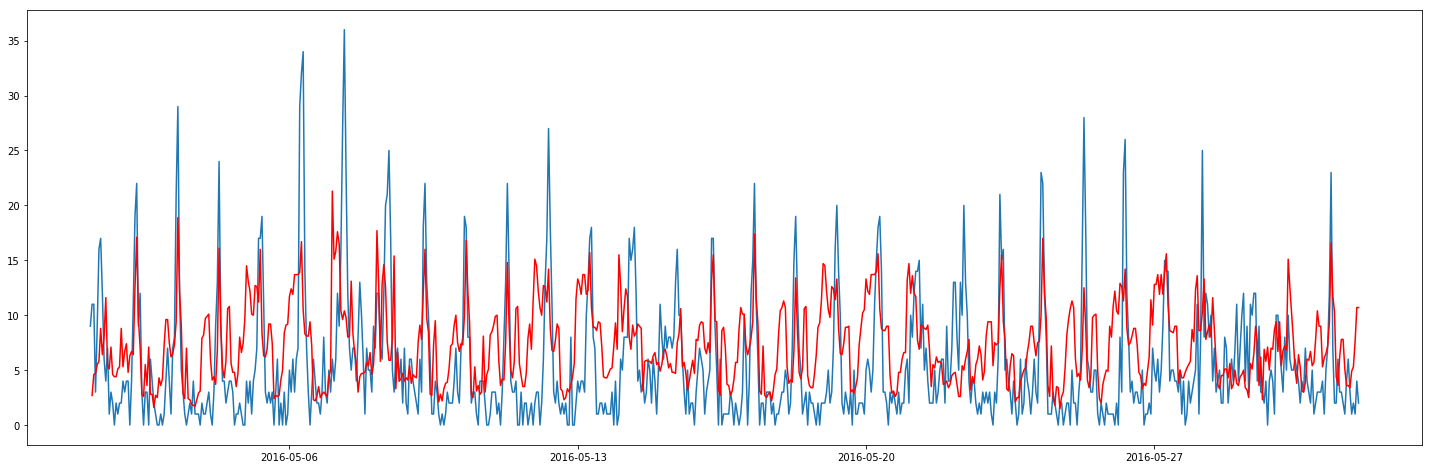

In [1456]:
plot_predict(data[[1580]][2908:3648], predict_may6[[1580]])

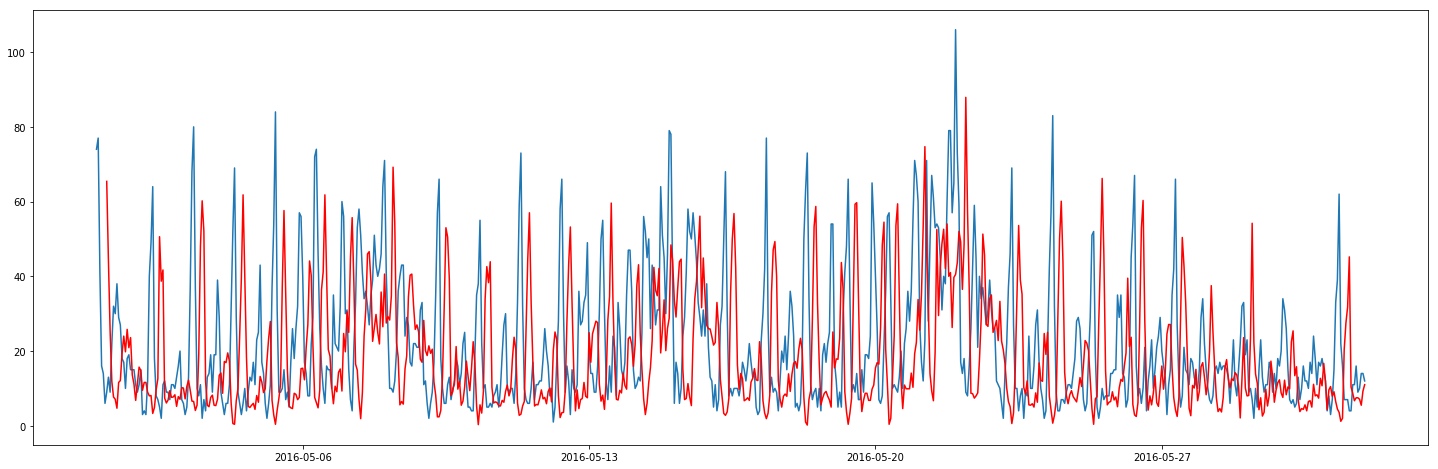

In [1457]:
plot_predict(data[[1173]][2903:3648], predict_may1[[1173]])

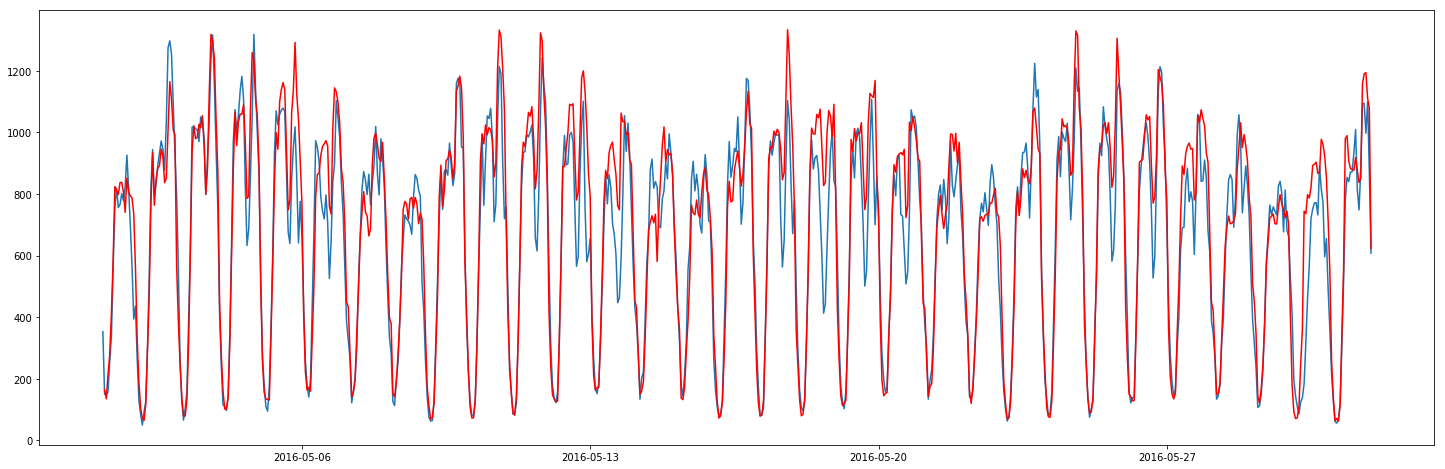

In [1458]:
plot_predict(data[[1231]][2908:3648], predict_may6[[1231]])

Ошибка полученных прогнозов

In [1459]:
def error(predictions, data):
    error = 0
    for c in data.columns:
        single_row_sum = 0
        for i in range(0, 6):
            single_row_sum += np.array(map(lambda x: abs(x), (np.array(predictions[i][[c]]) - np.array(data[[c]][2904+i:3648 - 5 + i])))).sum()
        error += single_row_sum
    return error /102/739/6

In [1460]:
error([predict_may1,predict_may2,predict_may3,predict_may4,predict_may5,predict_may6], data)

22.444636144940599

#### Предсказание на июнь

In [1461]:
def get_ends_of_history(start, end):
    start_date = datetime.strptime(start, '%Y-%m-%d_%H')
    end_date = datetime.strptime(end, '%Y-%m-%d_%H')
    diff = end_date - start_date
    hours_diff = diff.total_seconds() / 3600
    
    date = start_date
    dates = []
    for i in range(1, int(hours_diff) + 2):
        hour = date.strftime('%Y-%m-%d_%H').split('_')[1]
        value = date.strftime('%Y-%m-%d_%H').split('_')[0]
        if (hour[0] == '0'):
            value = value + '_' + hour[1]
        else:
            value = value + '_' + hour
        dates.append(value)
        date = date + timedelta(hours=1)
    return dates

In [1462]:
ends_of_history = get_ends_of_history('2016-05-31_23', '2016-06-30_17')

In [1463]:
predict_june1 = predictions(data.index[3653:], data.columns, X_summary, rgs1)
predict_june2 = predictions(data.index[3653:], data.columns, X_summary, rgs2)
predict_june3 = predictions(data.index[3653:], data.columns, X_summary, rgs3)
predict_june4 = predictions(data.index[3653:], data.columns, X_summary, rgs4)
predict_june5 = predictions(data.index[3653:], data.columns, X_summary, rgs5)
predict_june6 = predictions(data.index[3653:], data.columns, X_summary, rgs6)

In [1464]:
predict_june1[predict_june1 < 0] = 0
predict_june2[predict_june2 < 0] = 0
predict_june3[predict_june3 < 0] = 0
predict_june4[predict_june4 < 0] = 0
predict_june5[predict_june5 < 0] = 0
predict_june6[predict_june6 < 0] = 0

In [1465]:
def get_predictions_for_region(region):
    df = pd.DataFrame(index = predict_june1.index)
    df[0] = predict_june1[[region]]
    df[1] = predict_june2[[region]]
    df[2] = predict_june3[[region]]
    df[3] = predict_june4[[region]]
    df[4] = predict_june5[[region]]
    df[5] = predict_june6[[region]]
    
    df.index = range(0, df.shape[0])
    return df

In [1466]:
dfs = []

count = 0
for c in data.columns:
    df = pd.DataFrame({'id': [], 'y':[]})
    predictions = get_predictions_for_region(c)
    for i in predictions.index:
        for j in range(0, 6):
            id = str(c) + '_' + ends_of_history[i] + '_' + str(j + 1)
            df = df.append({'id': id, 'y': predictions.iloc[i,j]}, ignore_index=True)
    count += 1
    dfs.append(df)
    print str(count) + ' regions processed'

res = pd.DataFrame({'id': [], 'y':[]})
for df in dfs:
    res = res.append(df)
res = res.set_index(keys='id')
res.to_csv('./2016_06_predictions_regression.csv')

1 regions processed
2 regions processed
3 regions processed
4 regions processed
5 regions processed
6 regions processed
7 regions processed
8 regions processed
9 regions processed
10 regions processed
11 regions processed
12 regions processed
13 regions processed
14 regions processed
15 regions processed
16 regions processed
17 regions processed
18 regions processed
19 regions processed
20 regions processed
21 regions processed
22 regions processed
23 regions processed
24 regions processed
25 regions processed
26 regions processed
27 regions processed
28 regions processed
29 regions processed
30 regions processed
31 regions processed
32 regions processed
33 regions processed
34 regions processed
35 regions processed
36 regions processed
37 regions processed
38 regions processed
39 regions processed
40 regions processed
41 regions processed
42 regions processed
43 regions processed
44 regions processed
45 regions processed
46 regions processed
47 regions processed
48 regions processed
4

https://www.kaggle.com/c/yellowtaxi/leaderboard